In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
from spacy import tokenizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
from gensim import corpora
from gensim.models import TfidfModel, LsiModel
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
data = pd.read_csv('fake_news_data.csv')

In [3]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [4]:
data.count()

title              198
text               198
date               198
fake_or_factual    198
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Count of Article Classification')

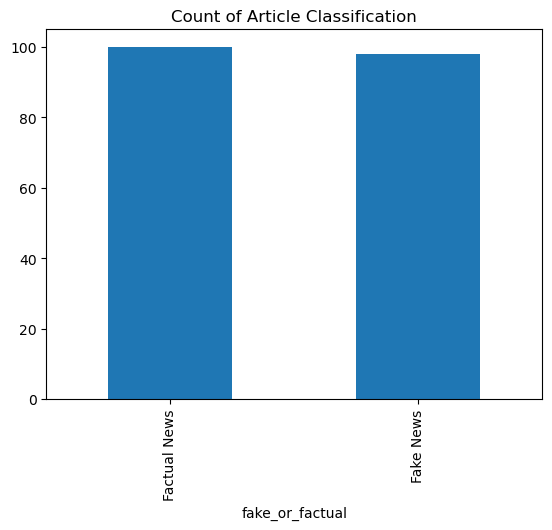

In [6]:
data['fake_or_factual'].value_counts().plot(kind='bar')
plt.title('Count of Article Classification')

**POS Tagging**

In [8]:
nlp = spacy.load('en_core_web_sm')

In [9]:
fake_news = data[data['fake_or_factual'] == 'Fake News']
fact_news = data[data['fake_or_factual'] == 'Factual News']

In [10]:
fake_spacydocs = list(nlp.pipe(fake_news['text']))
fact_spacydocs = list(nlp.pipe(fact_news['text']))

In [11]:
def extract_token_tags(doc: spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [12]:
fake_tagsdf = []
columns = ['token', 
         'ner_tag',
         'pos_tag']

In [13]:
for ix, doc in enumerate(fake_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)

In [14]:
tags.head()

,token,ner_tag,pos_tag
0,This,,PRON
1,is,,AUX
2,not,,PART
3,some,,DET
4,small,,ADJ


In [15]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   token    748 non-null    object
 1   ner_tag  748 non-null    object
 2   pos_tag  748 non-null    object
dtypes: object(3)
memory usage: 17.7+ KB


In [16]:
fake_tagsdf = pd.concat(fake_tagsdf)

In [17]:
fake_tagsdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45744 entries, 0 to 747
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   token    45744 non-null  object
 1   ner_tag  45744 non-null  object
 2   pos_tag  45744 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


In [18]:
fact_tagsdf = []

for ix, doc in enumerate(fact_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)

In [19]:
fact_tagsdf = pd.concat(fact_tagsdf)

In [20]:
fact_tagsdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40393 entries, 0 to 89
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   token    40393 non-null  object
 1   ner_tag  40393 non-null  object
 2   pos_tag  40393 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [21]:
pos_counts_fake = fake_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [22]:
pos_counts_fake.head()

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875


In [23]:
pos_counts_fact = fact_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [24]:
pos_counts_fact.head()

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789


In [25]:
pos_counts_fake.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: token, dtype: int64

In [26]:
pos_counts_fact.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
Name: token, dtype: int64

In [27]:
pos_counts_fact[pos_counts_fact['pos_tag'] == 'NOUN'].head(15)

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


In [28]:
pos_counts_fake[pos_counts_fake['pos_tag'] == 'NOUN'].head(15)

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


**Named Entities**

In [30]:
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ''].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts',ascending=False)

In [31]:
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ''].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts',ascending=False)

[Text(0.5, 1.0, 'Most Common Named Entities in Fake News')]

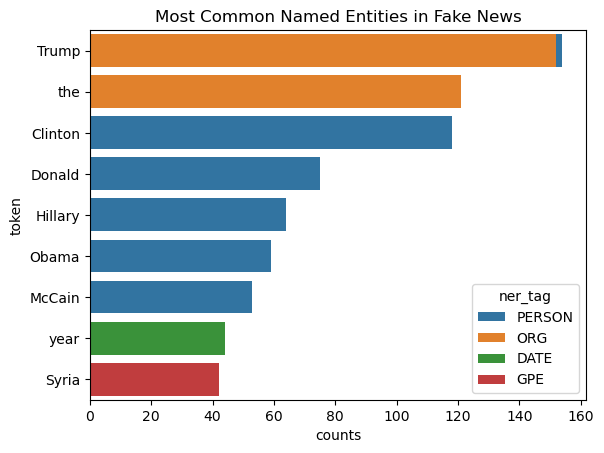

In [32]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    data = top_entities_fake[:10],
    orient='h',
    dodge=False
).set(title='Most Common Named Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Named Entities in Factual News')]

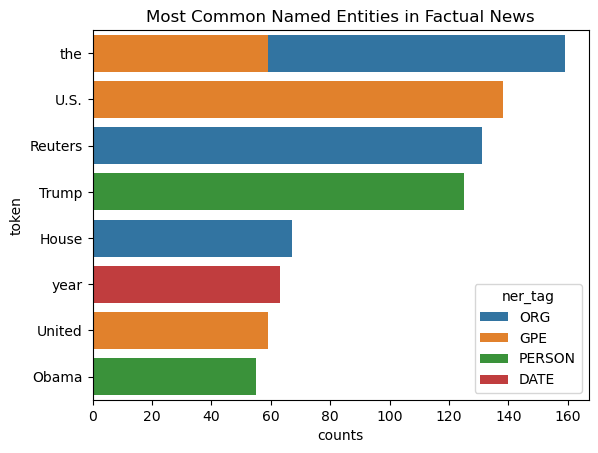

In [33]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    data = top_entities_fact[:10],
    orient='h',
    dodge=False
).set(title='Most Common Named Entities in Factual News')

**Text Pre-Processing**

In [35]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [36]:
data['text_clean'] = data.apply(lambda x: re.sub(r"^.*?\) -\s*", "", x['text']), axis = 1)

In [37]:
data['text_clean'].head()

0    There are two small problems with your analogy...
1    Buried in Trump s bonkers interview with New Y...
2    Women make up over 50 percent of this country,...
3    U.S. Defense Secretary Jim Mattis said on Mond...
4    Northern Ireland s political parties are rapid...
Name: text_clean, dtype: object

In [38]:
data['text_clean'] = data['text_clean'].str.lower()

In [39]:
data['text_clean'] = data['text_clean'].apply(lambda x: re.sub(r"([^\w\s])", "", x))

In [40]:
en_stopwords = stopwords.words('english')
print(en_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [41]:
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

In [42]:
data['text_clean'].head()

0    two small problems analogy susan jesus muslim ...
1    buried trump bonkers interview new york times ...
2    women make 50 percent country grossly underrep...
3    us defense secretary jim mattis said monday ru...
4    northern ireland political parties rapidly run...
Name: text_clean, dtype: object

In [43]:
data['text_clean'] = data.apply(lambda x: word_tokenize(x['text_clean']), axis=1)

In [44]:
lemmatizer = WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [45]:
data['text_clean'].head()

0    [two, small, problem, analogy, susan, jesus, m...
1    [buried, trump, bonkers, interview, new, york,...
2    [woman, make, 50, percent, country, grossly, u...
3    [u, defense, secretary, jim, mattis, said, mon...
4    [northern, ireland, political, party, rapidly,...
Name: text_clean, dtype: object

In [46]:
token_clean = sum(data['text_clean'], [])

In [47]:
unigrams = (pd.Series(nltk.ngrams(token_clean, 1)).value_counts())

In [48]:
print(unigrams[:10])

(said,)          580
(trump,)         580
(u,)             277
(state,)         275
(president,)     259
(would,)         226
(one,)           160
(clinton,)       141
(year,)          139
(republican,)    137
Name: count, dtype: int64


In [49]:
bigrams = (pd.Series(nltk.ngrams(token_clean, 2)).value_counts())

In [50]:
print(bigrams[:10])

(donald, trump)            113
(united, state)             84
(white, house)              74
(president, donald)         47
(hillary, clinton)          39
(new, york)                 33
(supreme, court)            30
(image, via)                29
(trump, administration)     26
(official, said)            26
Name: count, dtype: int64


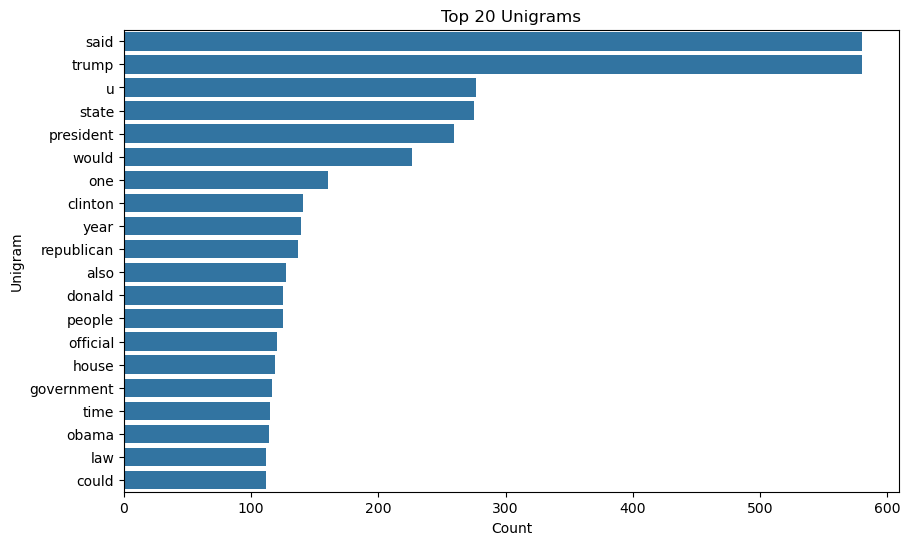

In [51]:
# Convert the Series to a DataFrame for plotting
unigrams_df = unigrams.reset_index(name='count')
unigrams_df.columns = ['unigram', 'count']

# Convert the unigram tuple back to string for readability
unigrams_df['unigram'] = unigrams_df['unigram'].apply(lambda x: ' '.join(x))

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='unigram', data=unigrams_df.head(20))

# Optional: set labels and title
plt.xlabel('Count')
plt.ylabel('Unigram')
plt.title('Top 20 Unigrams')

# Show the plot
plt.show()

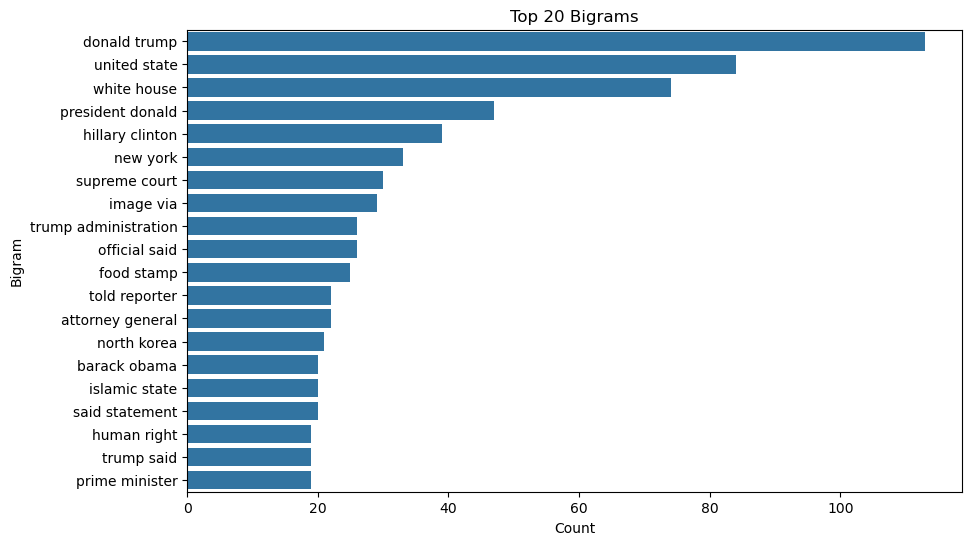

In [52]:
# Convert the Series to a DataFrame for plotting
bigrams_df = bigrams.reset_index(name='count')
bigrams_df.columns = ['bigram', 'count']

# Convert the bigram tuple back to a string for readability
bigrams_df['bigram'] = bigrams_df['bigram'].apply(lambda x: ' '.join(x))

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='bigram', data=bigrams_df.head(20))

# Optional: set labels and title
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Top 20 Bigrams')

# Show the plot
plt.show()

**Sentiment Analysis**

In [54]:
vader_sentiment = SentimentIntensityAnalyzer()

In [55]:
data['vader_sentiment_score'] = data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])

In [56]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [57]:
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

In [58]:
data['sentiment_category'] = pd.cut(data['vader_sentiment_score'], bins=bins, labels=names, include_lowest=True)

In [59]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,sentiment_category
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


<Axes: xlabel='sentiment_category'>

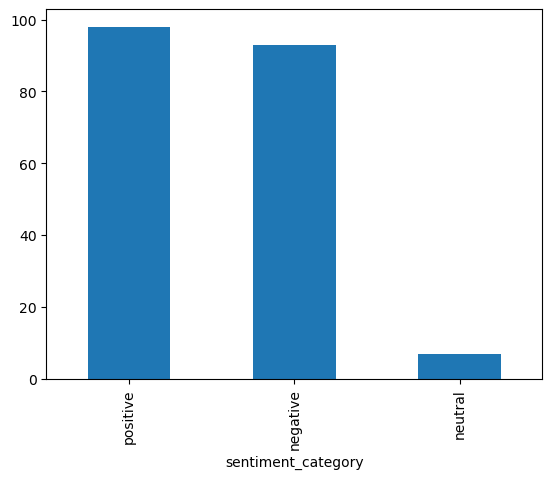

In [60]:
data['sentiment_category'].value_counts().plot.bar()

<Axes: xlabel='sentiment_category'>

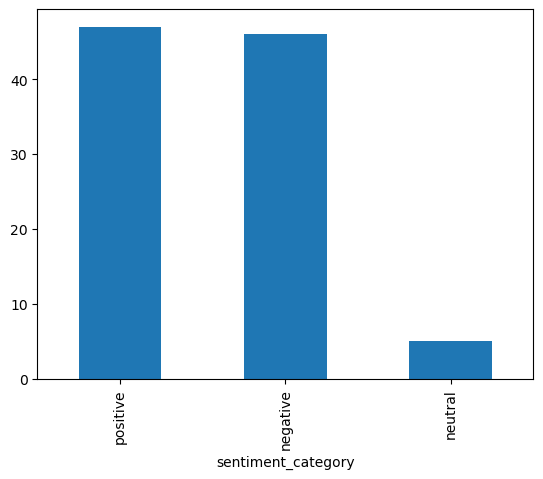

In [61]:
data[data['fake_or_factual']=='Fake News']['sentiment_category'].value_counts().plot.bar()

<Axes: xlabel='sentiment_category'>

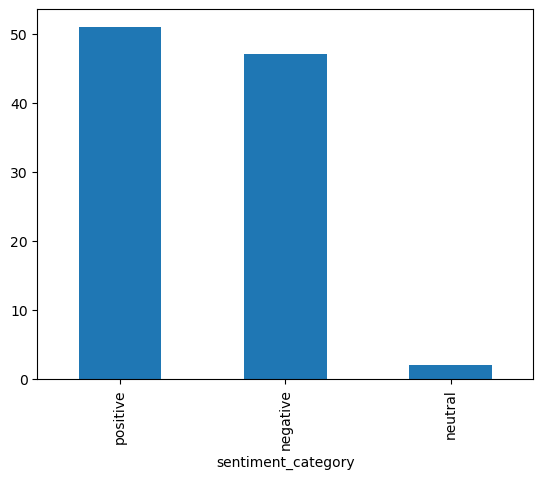

In [62]:
data[data['fake_or_factual']=='Factual News']['sentiment_category'].value_counts().plot.bar()

<Axes: xlabel='fake_or_factual', ylabel='count'>

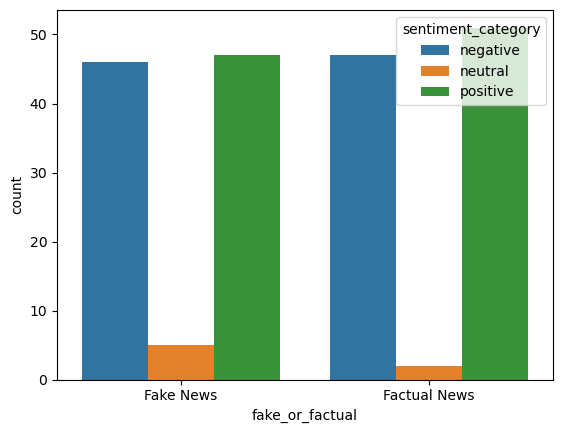

In [63]:
sns.countplot(
    x = 'fake_or_factual',
    hue = 'sentiment_category',
    data = data
)

**Topic Modelling**

In [65]:
fake_news_text = data[data['fake_or_factual']=='Fake News']['text_clean'].reset_index(drop=True)

In [66]:
dictionary_fake = corpora.Dictionary(fake_news_text)
print(dictionary_fake)

Dictionary<6425 unique tokens: ['16yearold', '69yearold', 'accompanying', 'actor', 'actress']...>


In [67]:
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

In [68]:
print(doc_term_fake)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 4), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 4), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 2), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 3), (59, 3), (60, 1), (61, 3), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 3), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 2), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 6), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 2), (103, 1), (104, 2), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 2)

In [69]:
coherance_values = []
models_list = []

min_topics = 2
max_topics = 11

In [70]:
for i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=i, id2word=dictionary_fake)
    models_list.append(model)
    coherence_score = CoherenceModel(model=model, dictionary=dictionary_fake, texts=fake_news_text, coherence='c_v')
    coherance_values.append(coherence_score.get_coherence())

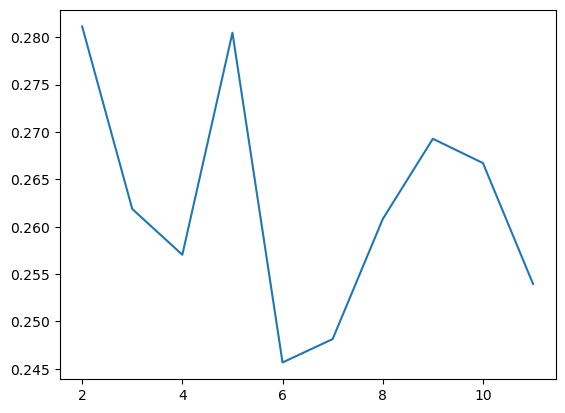

In [71]:
plt.plot(range(min_topics, max_topics+1), coherance_values)

In [72]:
print(coherance_values)

[0.28112191440345025, 0.2618724408908784, 0.25704005994770934, 0.28046359976376606, 0.24567629559020435, 0.24814584453709226, 0.2608055977963445, 0.26927453897188897, 0.26671474963305236, 0.25395876575643966]


In [73]:
final_num_topics = 6
lda_model = gensim.models.LdaModel(doc_term_fake, num_topics=final_num_topics, id2word=dictionary_fake)

In [74]:
lda_model.print_topics(num_topics=6, num_words=10)

[(0,
  '0.014*"trump" + 0.006*"president" + 0.006*"said" + 0.005*"woman" + 0.005*"republican" + 0.004*"one" + 0.004*"clinton" + 0.004*"would" + 0.003*"state" + 0.003*"u"'),
 (1,
  '0.009*"trump" + 0.005*"state" + 0.005*"one" + 0.004*"said" + 0.004*"president" + 0.004*"u" + 0.003*"time" + 0.003*"republican" + 0.003*"would" + 0.003*"clinton"'),
 (2,
  '0.010*"trump" + 0.004*"said" + 0.004*"clinton" + 0.004*"president" + 0.004*"u" + 0.004*"would" + 0.003*"time" + 0.003*"people" + 0.003*"state" + 0.003*"one"'),
 (3,
  '0.007*"trump" + 0.006*"state" + 0.005*"clinton" + 0.005*"u" + 0.005*"said" + 0.004*"would" + 0.003*"president" + 0.003*"people" + 0.003*"time" + 0.003*"hillary"'),
 (4,
  '0.015*"trump" + 0.005*"president" + 0.004*"said" + 0.004*"obama" + 0.004*"clinton" + 0.003*"donald" + 0.003*"know" + 0.003*"time" + 0.003*"go" + 0.003*"people"'),
 (5,
  '0.010*"trump" + 0.004*"president" + 0.003*"state" + 0.003*"clinton" + 0.003*"campaign" + 0.003*"said" + 0.003*"one" + 0.003*"year" + 0.0

In [75]:
def tfidf_corpus(doc_term_matrix):
    tfidf = TfidfModel(doc_term_matrix, normalize=True)
    tfidf_corpus = tfidf[doc_term_matrix]
    return tfidf_corpus

In [76]:
def get_coherence_score(corpus, dictionary, text, min_topics, max_topics):
    coherence_values = []
    model_list = []
    for i in range(min_topics, max_topics+1):
        model = gensim.models.LsiModel(corpus, num_topics=i, id2word=dictionary)
        model_list.append(model)
        coherence_score = CoherenceModel(model = model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_score.get_coherence())
    plt.plot(range(min_topics, max_topics+1), coherance_values)

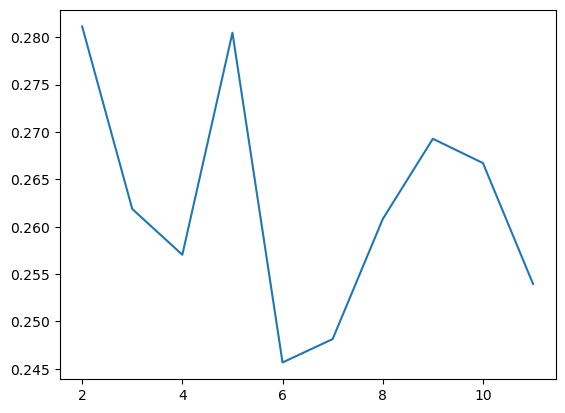

In [77]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)
get_coherence_score(corpus_tfidf_fake, dictionary_fake, fake_news_text, 2, 11)

In [78]:
lsa_model = LsiModel(corpus_tfidf_fake, num_topics=6, id2word=dictionary_fake)

In [79]:
lsa_model.print_topics(num_topics=6, num_words=10)

[(0,
  '-0.190*"trump" + -0.136*"clinton" + -0.095*"hillary" + -0.094*"obama" + -0.091*"woman" + -0.089*"president" + -0.078*"republican" + -0.077*"flynn" + -0.077*"party" + -0.074*"candidate"'),
 (1,
  '-0.326*"boiler" + -0.284*"acr" + -0.244*"room" + -0.240*"pm" + -0.186*"broadcast" + -0.180*"radio" + -0.142*"tune" + -0.142*"animal" + -0.134*"jay" + -0.132*"episode"'),
 (2,
  '0.622*"flynn" + 0.181*"immunity" + 0.122*"nana" + 0.116*"mr" + 0.111*"march" + 0.110*"30" + 0.102*"russian" + 0.099*"source" + -0.096*"school" + 0.092*"adviser"'),
 (3,
  '-0.217*"clinton" + 0.185*"school" + 0.176*"student" + -0.142*"hillary" + 0.125*"flynn" + 0.122*"county" + -0.110*"sander" + -0.098*"woman" + -0.097*"debate" + -0.091*"nominee"'),
 (4,
  '-0.201*"email" + 0.192*"trump" + -0.168*"dnc" + 0.139*"flynn" + -0.126*"clinton" + 0.112*"cruz" + -0.111*"department" + -0.110*"rich" + -0.102*"wikileaks" + -0.099*"sander"'),
 (5,
  '0.274*"student" + 0.172*"conference" + 0.157*"school" + 0.141*"trump" + -0.

**Creating our classification model**

In [81]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,sentiment_category
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [82]:
X = [','.join(map(str,l)) for l in data['text_clean']]

In [83]:
Y = data['fake_or_factual']

In [84]:
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)

In [85]:
print(countvec_fit)

  (0, 8446)	1
  (0, 7545)	1
  (0, 6378)	1
  (0, 681)	1
  (0, 7968)	1
  (0, 4525)	1
  (0, 5431)	2
  (0, 4562)	3
  (0, 8343)	1
  (0, 1148)	1
  (0, 5106)	3
  (0, 760)	1
  (0, 5990)	1
  (0, 930)	1
  (0, 781)	1
  (0, 5069)	1
  (0, 3255)	1
  (0, 6715)	6
  (0, 400)	1
  (0, 5030)	1
  (0, 3702)	1
  (0, 7163)	2
  (0, 7667)	2
  (0, 1644)	1
  (0, 3991)	1
  :	:
  (197, 4213)	1
  (197, 9031)	2
  (197, 475)	1
  (197, 2533)	1
  (197, 6478)	1
  (197, 2563)	1
  (197, 3897)	1
  (197, 2877)	1
  (197, 7513)	1
  (197, 8517)	1
  (197, 1582)	1
  (197, 2786)	1
  (197, 780)	1
  (197, 2583)	1
  (197, 668)	1
  (197, 3545)	1
  (197, 283)	1
  (197, 8469)	2
  (197, 4762)	1
  (197, 8627)	1
  (197, 8468)	1
  (197, 6751)	1
  (197, 6199)	1
  (197, 3672)	1
  (197, 6054)	1


In [86]:
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns=countvec.get_feature_names_out())

In [87]:
x_train, x_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size = 0.3)

In [88]:
lr = LogisticRegression(random_state=0).fit(x_train, y_train)

In [89]:
y_pred_lr = lr.predict(x_test)

In [90]:
accuracy_score(y_pred_lr, y_test)

0.8833333333333333

In [91]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.90      0.87      0.88        30
   Fake News       0.87      0.90      0.89        30

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



In [92]:
svm = SGDClassifier().fit(x_train, y_train)

In [93]:
y_pred_svm = svm.predict(x_test)

In [94]:
accuracy_score(y_pred_svm, y_test)

0.9

In [95]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.90      0.90      0.90        30
   Fake News       0.90      0.90      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60

